# Plankton food web grazing fluxes between cold and warm periods  
### Here, I will plot the fraction between net autotrophic and net heterotrophic grazing fluxes by adding the grazing fluxes from phytoplankton to zooplankton in the nominator and the grazing fluxes between zooplankton and other zooplankton in the denominator. 
    - values less than 1 = Net heterotrophic fluxes dominate 
    - values equal to 1 = net heterorophy equals net autotrophy
    - values less than 1 = net autotophy domaintes. 
    
### 1. Load the phytoplankton grazing on zooplankton fluxes, sum and save 
### 2. Load the zooplankton grazing on zooplankton fluxes, sum and save
### 3. Load the previous two and plot the figures! 

In [2]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os
import matplotlib.gridspec as gridspec

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## 1.  Load the datafiles for the 62 years of the 2$^{nd}$ cycle 
    path = '/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009'
    files = sorted(glob.glob(f'{path}/SPECTRA_*.nc', recursive=True),key=numericalSort)
    ds= xr.open_mfdataset(files,combine='by_coords')

In [4]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

variables = [f'{var}' for var in ['graze_diaz_zoo1','graze_diaz_zoo2','graze_diaz_zoo3',
                                  'graze_pp_zoo1',
                                  'graze_mp1_zoo1','graze_mp1_zoo2',
                                  'graze_mp2_zoo2','graze_mp2_zoo3','graze_mp2_zoo4',
                                  'graze_mp3_zoo3','graze_mp3_zoo4','graze_mp3_zoo5',
                                  'graze_mp4_zoo4','graze_mp4_zoo5','graze_mp4_zoo6',
                                  'graze_diat1_zoo1','graze_diat1_zoo2','graze_diat1_zoo3','graze_diat1_zoo4',
                                  'graze_diat2_zoo2','graze_diat2_zoo3','graze_diat2_zoo4','graze_diat2_zoo5',
                                  'graze_diat3_zoo3','graze_diat3_zoo4','graze_diat3_zoo5','graze_diat3_zoo6',
                                 ]]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [5]:
%%time

ds_summer_avg = xr.Dataset()
ds_spring_avg = xr.Dataset()
ds_fall_avg = xr.Dataset()
ds_winter_avg =xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_summer = xr.Dataset()
    ds_spring = xr.Dataset()
    ds_winter = xr.Dataset()
    ds_fall = xr.Dataset()

    file = sorted(glob.glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    winter_indexes = [0,1,-1]
    winter_files = [file[ind] for ind in winter_indexes]
    dsv_winter=xr.open_mfdataset(winter_files, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
        
    dsv_summer=xr.open_mfdataset(file[5:8], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_spring=xr.open_mfdataset(file[2:5], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_fall=xr.open_mfdataset(file[8:11], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_summer = xr.merge((ds_summer, dsv_summer[vv]))
        ds_spring = xr.merge((ds_spring, dsv_spring[vv]))
        ds_winter = xr.merge((ds_winter, dsv_winter[vv]))
        ds_fall = xr.merge((ds_fall, dsv_fall[vv]))
        

    ds_summer = ds_summer.drop([v for v in ds_summer.variables if v not in keep_vars]).squeeze()
    ds_summer = ds_summer.mean(dim='time')
    ds_summer_avg = xr.concat([ds_summer_avg, ds_summer],dim='year')
    
    ds_spring = ds_spring.drop([v for v in ds_spring.variables if v not in keep_vars]).squeeze()
    ds_spring = ds_spring.mean(dim='time')
    ds_spring_avg = xr.concat([ds_spring_avg, ds_spring],dim='year')
    
    ds_winter = ds_winter.drop([v for v in ds_winter.variables if v not in keep_vars]).squeeze()
    ds_winter = ds_winter.mean(dim='time')
    ds_winter_avg = xr.concat([ds_winter_avg, ds_winter],dim='year')
    
    ds_fall = ds_fall.drop([v for v in ds_fall.variables if v not in keep_vars]).squeeze()
    ds_fall = ds_fall.mean(dim='time')
    ds_fall_avg = xr.concat([ds_fall_avg, ds_fall],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 14min 37s, sys: 13min 50s, total: 28min 27s
Wall time: 32min 21s


## We want grazing from zooplankton to zooplankton & phytoplankton to zooplankton

In [6]:
## Gaby's Path 
gabyn_path = '/glade/u/home/gabyn/work/case_notes/spectral_cases/g.e21.G1850ECOIAF.t62_g17.marbl0_33.'
nl_config = os.path.join(''+gabyn_path+'GNG595/data/')
sizes = pd.read_csv(nl_config+'plankton_sizes.csv')
sizes = sizes.sort_values('mmolC')
sizes

,type,sname,mass_ugC,vol_um3,ESD_mm,Qp_fixed,mmolC
1,phyto,pp,9.266989e-08,3.706795e-01,0.000891,0.004651,7.715418e-12
2,phyto,mp1,8.241979e-06,1.805089e+01,0.003255,0.006824,6.862025e-10
0,phyto,diaz,5.499929e-05,1.227865e+02,0.006167,0.003333,4.579077e-09
3,phyto,mp2,8.888712e-05,8.790197e+02,0.011885,0.008656,7.400476e-09
6,phyto,diat1,5.004513e-04,1.327390e+04,0.029376,0.010289,4.166608e-08
9,zoo,zoo1,2.803686e-03,2.355042e+04,0.035563,0.008547,2.334265e-07
7,phyto,diat2,3.803133e-03,1.326626e+05,0.063278,0.012602,3.166375e-07
4,phyto,mp3,4.830334e-03,4.280541e+04,0.043401,0.012907,4.021592e-07
8,phyto,diat3,2.890156e-02,1.325863e+06,0.136301,0.015435,2.406258e-06
10,zoo,zoo2,8.933984e-02,7.447577e+05,0.112462,0.008547,7.438168e-06


In [7]:
prey_varnames = {}
for i,v in enumerate(sizes.sname):
    prey_varnames[v]=i

In [8]:
grazing_vars = [v for v in ds_fall_avg if 'graze' in v and 'zint' not in v]

In [9]:
phyto_grazing = grazing_vars[0:27] # only the zooplankton and phytoplankton grazing. 

In [10]:
%%time
phyto_zoo_winter = xr.concat([ds_winter_avg[w]for w in phyto_grazing],dim='new_dim')# units are mmol/m^3/s
phyto_zoo_spring = xr.concat([ds_spring_avg[w]for w in phyto_grazing],dim='new_dim')# units are mmol/m^3/s
phyto_zoo_summer = xr.concat([ds_summer_avg[w]for w in phyto_grazing],dim='new_dim')# units are mmol/m^3/s
phyto_zoo_fall = xr.concat([ds_fall_avg[w]for w in phyto_grazing],dim='new_dim')# units are mmol/m^3/s

CPU times: user 206 ms, sys: 4.79 ms, total: 211 ms
Wall time: 212 ms


In [11]:
phyto_zoo_winter.shape

(27, 63, 15, 384, 320)

In [12]:
%%time
phyto_zoo_sum_winter = np.sum(phyto_zoo_winter,axis=0)
phyto_zoo_sum_spring = np.sum(phyto_zoo_spring,axis=0)
phyto_zoo_sum_summer = np.sum(phyto_zoo_summer,axis=0)
phyto_zoo_sum_fall = np.sum(phyto_zoo_fall,axis=0)

CPU times: user 321 ms, sys: 11.3 ms, total: 332 ms
Wall time: 335 ms


In [13]:
%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/phyto_zoo_sum_winter.npy",phyto_zoo_sum_winter)

CPU times: user 2min 7s, sys: 4min 42s, total: 6min 50s
Wall time: 12min 12s


In [14]:
%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/phyto_zoo_sum_spring.npy",phyto_zoo_sum_spring)

CPU times: user 2min 6s, sys: 5min 1s, total: 7min 8s
Wall time: 12min 40s


In [15]:
%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/phyto_zoo_sum_summer.npy",phyto_zoo_sum_summer)

CPU times: user 2min 6s, sys: 4min 54s, total: 7min
Wall time: 12min 31s


In [16]:
%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/phyto_zoo_sum_fall.npy",phyto_zoo_sum_fall)

CPU times: user 2min 6s, sys: 4min 59s, total: 7min 5s
Wall time: 12min 21s


## 2. Now import the zooplankton grazing on zooplankton grazing fluxes for each of the seasons.. 

In [5]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

variables = [f'{var}' for var in ['graze_zoo1_zoo2','graze_zoo1_zoo3',
                                  'graze_zoo2_zoo3','graze_zoo2_zoo4',
                                  'graze_zoo3_zoo4','graze_zoo3_zoo5',
                                  'graze_zoo4_zoo5','graze_zoo4_zoo6',
                                  'graze_zoo5_zoo6',
                                 ]]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [6]:
%%time

ds_summer_avg = xr.Dataset()
ds_spring_avg = xr.Dataset()
ds_fall_avg = xr.Dataset()
ds_winter_avg =xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_summer = xr.Dataset()
    ds_spring = xr.Dataset()
    ds_winter = xr.Dataset()
    ds_fall = xr.Dataset()

    file = sorted(glob.glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    winter_indexes = [0,1,-1]
    winter_files = [file[ind] for ind in winter_indexes]
    dsv_winter=xr.open_mfdataset(winter_files, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
        
    dsv_summer=xr.open_mfdataset(file[5:8], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_spring=xr.open_mfdataset(file[2:5], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_fall=xr.open_mfdataset(file[8:11], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_summer = xr.merge((ds_summer, dsv_summer[vv]))
        ds_spring = xr.merge((ds_spring, dsv_spring[vv]))
        ds_winter = xr.merge((ds_winter, dsv_winter[vv]))
        ds_fall = xr.merge((ds_fall, dsv_fall[vv]))
        

    ds_summer = ds_summer.drop([v for v in ds_summer.variables if v not in keep_vars]).squeeze()
    ds_summer = ds_summer.mean(dim='time')
    ds_summer_avg = xr.concat([ds_summer_avg, ds_summer],dim='year')
    
    ds_spring = ds_spring.drop([v for v in ds_spring.variables if v not in keep_vars]).squeeze()
    ds_spring = ds_spring.mean(dim='time')
    ds_spring_avg = xr.concat([ds_spring_avg, ds_spring],dim='year')
    
    ds_winter = ds_winter.drop([v for v in ds_winter.variables if v not in keep_vars]).squeeze()
    ds_winter = ds_winter.mean(dim='time')
    ds_winter_avg = xr.concat([ds_winter_avg, ds_winter],dim='year')
    
    ds_fall = ds_fall.drop([v for v in ds_fall.variables if v not in keep_vars]).squeeze()
    ds_fall = ds_fall.mean(dim='time')
    ds_fall_avg = xr.concat([ds_fall_avg, ds_fall],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 9min 56s, sys: 4min 21s, total: 14min 18s
Wall time: 16min 37s


In [7]:
zoo_grazing = [v for v in ds_fall_avg if 'graze' in v and 'zint' not in v]

In [8]:
zoo_grazing

['graze_zoo1_zoo2',
 'graze_zoo1_zoo3',
 'graze_zoo2_zoo3',
 'graze_zoo2_zoo4',
 'graze_zoo3_zoo4',
 'graze_zoo3_zoo5',
 'graze_zoo4_zoo5',
 'graze_zoo4_zoo6',
 'graze_zoo5_zoo6']

In [9]:
%%time
zoo_zoo_winter = xr.concat([ds_winter_avg[w]for w in zoo_grazing],dim='new_dim')# units are mmol/m^3/s
zoo_zoo_spring = xr.concat([ds_spring_avg[w]for w in zoo_grazing],dim='new_dim')# units are mmol/m^3/s
zoo_zoo_summer = xr.concat([ds_summer_avg[w]for w in zoo_grazing],dim='new_dim')# units are mmol/m^3/s
zoo_zoo_fall = xr.concat([ds_fall_avg[w]for w in zoo_grazing],dim='new_dim')# units are mmol/m^3/s

CPU times: user 60.7 ms, sys: 770 µs, total: 61.4 ms
Wall time: 61.5 ms


In [10]:
%%time
zoo_zoo_sum_winter = np.sum(zoo_zoo_winter,axis=0)
zoo_zoo_sum_spring = np.sum(zoo_zoo_spring,axis=0)
zoo_zoo_sum_summer = np.sum(zoo_zoo_summer,axis=0)
zoo_zoo_sum_fall = np.sum(zoo_zoo_fall,axis=0)

CPU times: user 91.3 ms, sys: 4.33 ms, total: 95.6 ms
Wall time: 97.1 ms


In [23]:
%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/zoo_zoo_sum_winter.npy",zoo_zoo_sum_winter)

CPU times: user 42.3 s, sys: 3min, total: 3min 43s
Wall time: 5min 1s


In [11]:
%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/zoo_zoo_sum_spring.npy",zoo_zoo_sum_spring)

CPU times: user 42.5 s, sys: 3min 1s, total: 3min 44s
Wall time: 5min 1s


In [12]:
%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/zoo_zoo_sum_summer.npy",zoo_zoo_sum_summer)

CPU times: user 40.9 s, sys: 3min 3s, total: 3min 44s
Wall time: 5min


In [13]:
%%time
np.save("/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/zoo_zoo_sum_fall.npy",zoo_zoo_sum_fall)

CPU times: user 41.3 s, sys: 3min 1s, total: 3min 42s
Wall time: 4min 58s


# 3.  Import the npy files that we have created 

In [14]:
path = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/'
phyto_zoo_sum_winter = np.load(f'{path}phyto_zoo_sum_winter.npy')
phyto_zoo_sum_spring = np.load(f'{path}phyto_zoo_sum_spring.npy')
phyto_zoo_sum_summer = np.load(f'{path}phyto_zoo_sum_summer.npy')
phyto_zoo_sum_fall = np.load(f'{path}phyto_zoo_sum_fall.npy')

In [15]:
path = '/glade/derecho/scratch/gabyn/SPECTRA_hindcast/GNG595_npy_files/grazing/'
zoo_zoo_sum_winter = np.load(f'{path}zoo_zoo_sum_winter.npy')
zoo_zoo_sum_spring = np.load(f'{path}zoo_zoo_sum_spring.npy')
zoo_zoo_sum_summer = np.load(f'{path}zoo_zoo_sum_summer.npy')
zoo_zoo_sum_fall = np.load(f'{path}zoo_zoo_sum_fall.npy')

#### Check units 
    zoo_zoo_grazing_150m =  np.sum(zoo_zoo_grazing, axis=2) * 10/150 *(60*60*24*365) #integrate over depth #mmol m-3 y-1

In [16]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

In [17]:
phyto_zoo_winter = np.nanmean(np.sum(phyto_zoo_sum_winter, axis=1) * 10/150 *(60*60*24*365),axis=0) #integrate over depth #mmol m-3 y-1
phyto_zoo_spring = np.nanmean(np.sum(phyto_zoo_sum_spring, axis=1) * 10/150 *(60*60*24*365),axis=0) #integrate over depth #mmol m-3 y-1
phyto_zoo_summer = np.nanmean(np.sum(phyto_zoo_sum_summer, axis=1) * 10/150 *(60*60*24*365),axis=0) #integrate over depth #mmol m-3 y-1
phyto_zoo_fall = np.nanmean(np.sum(phyto_zoo_sum_fall, axis=1) * 10/150 *(60*60*24*365),axis=0) #integrate over depth #mmol m-3 y-1

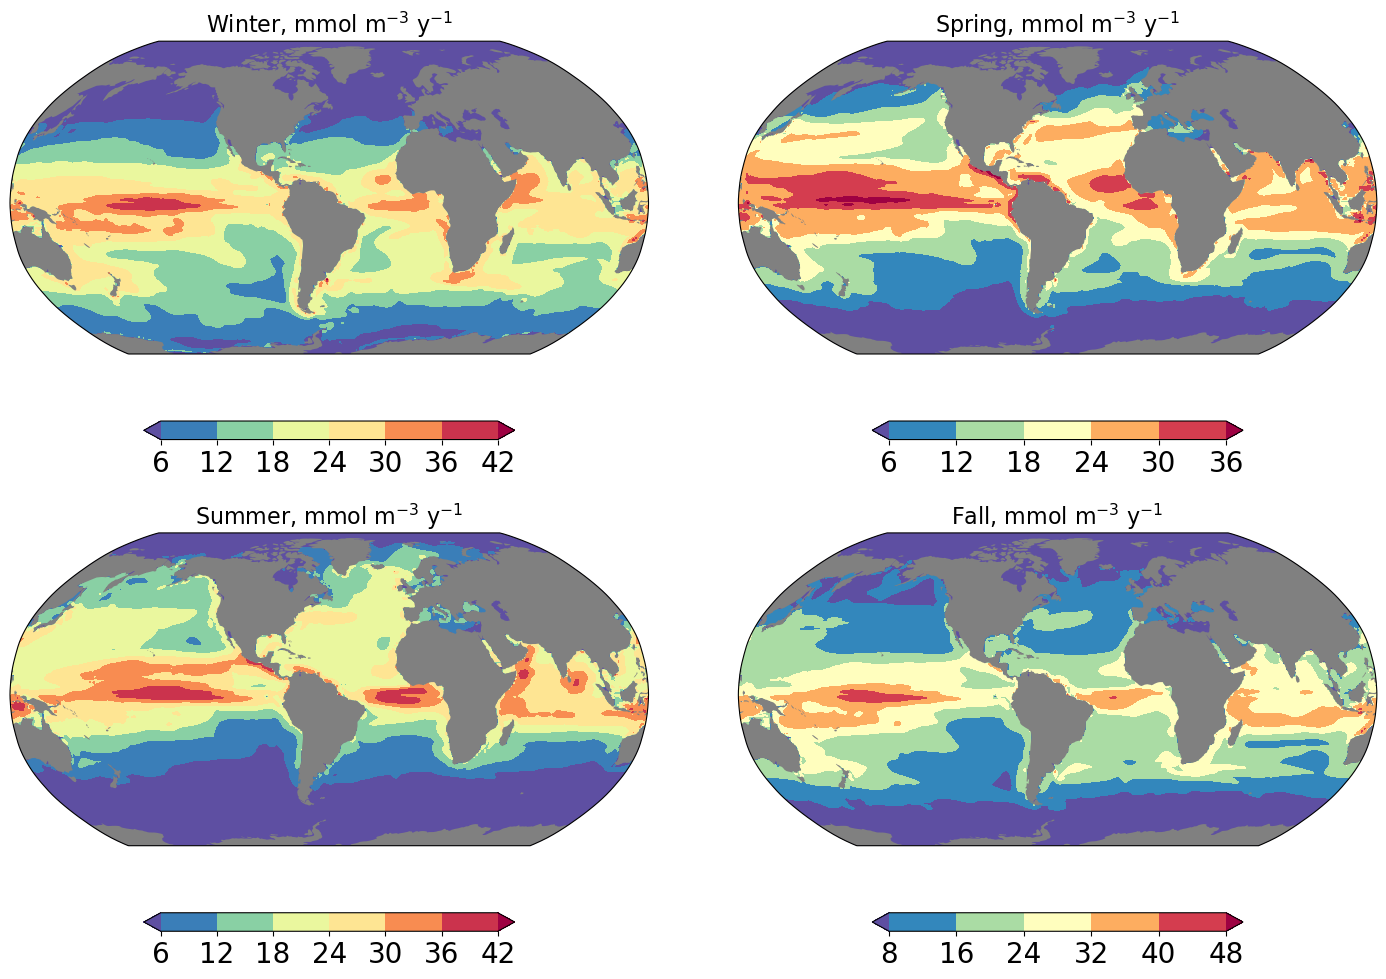

In [18]:
fig = plt.figure(figsize=(15, 10))
lat = ds.TLAT
lev = np.arange(0, 10, 0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)

## WINTER 
ax = fig.add_subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_zoo_winter)
cf = ax.contourf(tlon, tlat, phyto, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter, mmol m$^{-3}$ y$^{-1}$', fontsize =16)


## SPRING
ax = fig.add_subplot(2, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_zoo_spring)
cf = ax.contourf(tlon, tlat, phyto, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Spring, mmol m$^{-3}$ y$^{-1}$', fontsize =16)

## SUMMER
ax = fig.add_subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_zoo_summer)
cf = ax.contourf(tlon, tlat, phyto,  extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Summer, mmol m$^{-3}$ y$^{-1}$', fontsize =16)


##FALL
ax = fig.add_subplot(2, 2, 4, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_zoo_fall)
cf = ax.contourf(tlon, tlat, phyto, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Fall, mmol m$^{-3}$ y$^{-1}$', fontsize =16);
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/work/case_notes/analysis_figures/global_phyto_zoo_grazing_fluxes_quarterly_150m.png',dpi=200, bbox_inches='tight')

## Now do the same for all zooplankton! 

In [19]:
%%time
zoo_zoo_winter = np.nanmean(np.sum(zoo_zoo_sum_winter, axis=1) * 10/150 *(60*60*24*365),axis=0) #integrate over depth #mmol m-3 y-1
zoo_zoo_spring = np.nanmean(np.sum(zoo_zoo_sum_spring, axis=1) * 10/150 *(60*60*24*365),axis=0) #integrate over depth #mmol m-3 y-1
zoo_zoo_summer = np.nanmean(np.sum(zoo_zoo_sum_summer, axis=1) * 10/150 *(60*60*24*365),axis=0) #integrate over depth #mmol m-3 y-1
zoo_zoo_fall = np.nanmean(np.sum(zoo_zoo_sum_fall, axis=1) * 10/150 *(60*60*24*365),axis=0) #integrate over depth #mmol m-3 y-1

CPU times: user 351 ms, sys: 98 ms, total: 449 ms
Wall time: 457 ms


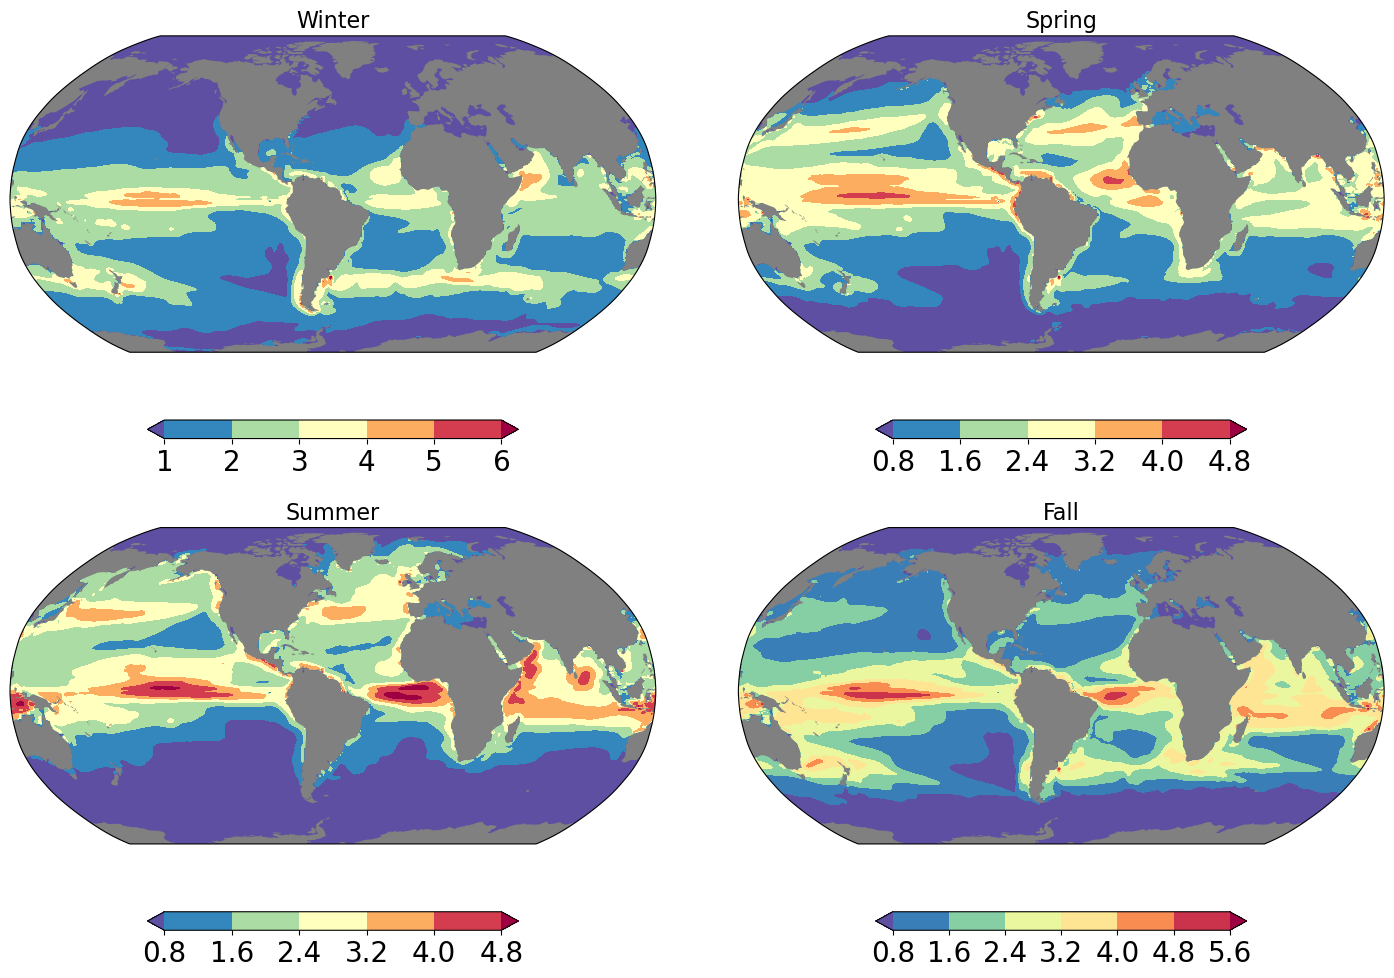

In [20]:
fig = plt.figure(figsize=(15, 10))
lat = ds.TLAT
lev = np.arange(0, 10, 0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=5)

## WINTER 
ax = fig.add_subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, zoo_zoo_winter)
cf = ax.contourf(tlon, tlat, phyto, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =16)


## SPRING
ax = fig.add_subplot(2, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, zoo_zoo_spring)
cf = ax.contourf(tlon, tlat, phyto, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =16)

## SUMMER
ax = fig.add_subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, zoo_zoo_summer)
cf = ax.contourf(tlon, tlat, phyto,  extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Summer', fontsize =16)


##FALL
ax = fig.add_subplot(2, 2, 4, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, zoo_zoo_fall)
cf = ax.contourf(tlon, tlat, phyto, extend='both',cmap='Spectral_r',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =16);
fig.tight_layout()

fig.savefig('/glade/u/home/gabyn/work/case_notes/analysis_figures/global_zoo_zoo_grazing_fluxes_quarterly_150m.png',dpi=200, bbox_inches='tight')

## Create a Fraction! 

## Winter, Spring, Summer and Fall. 

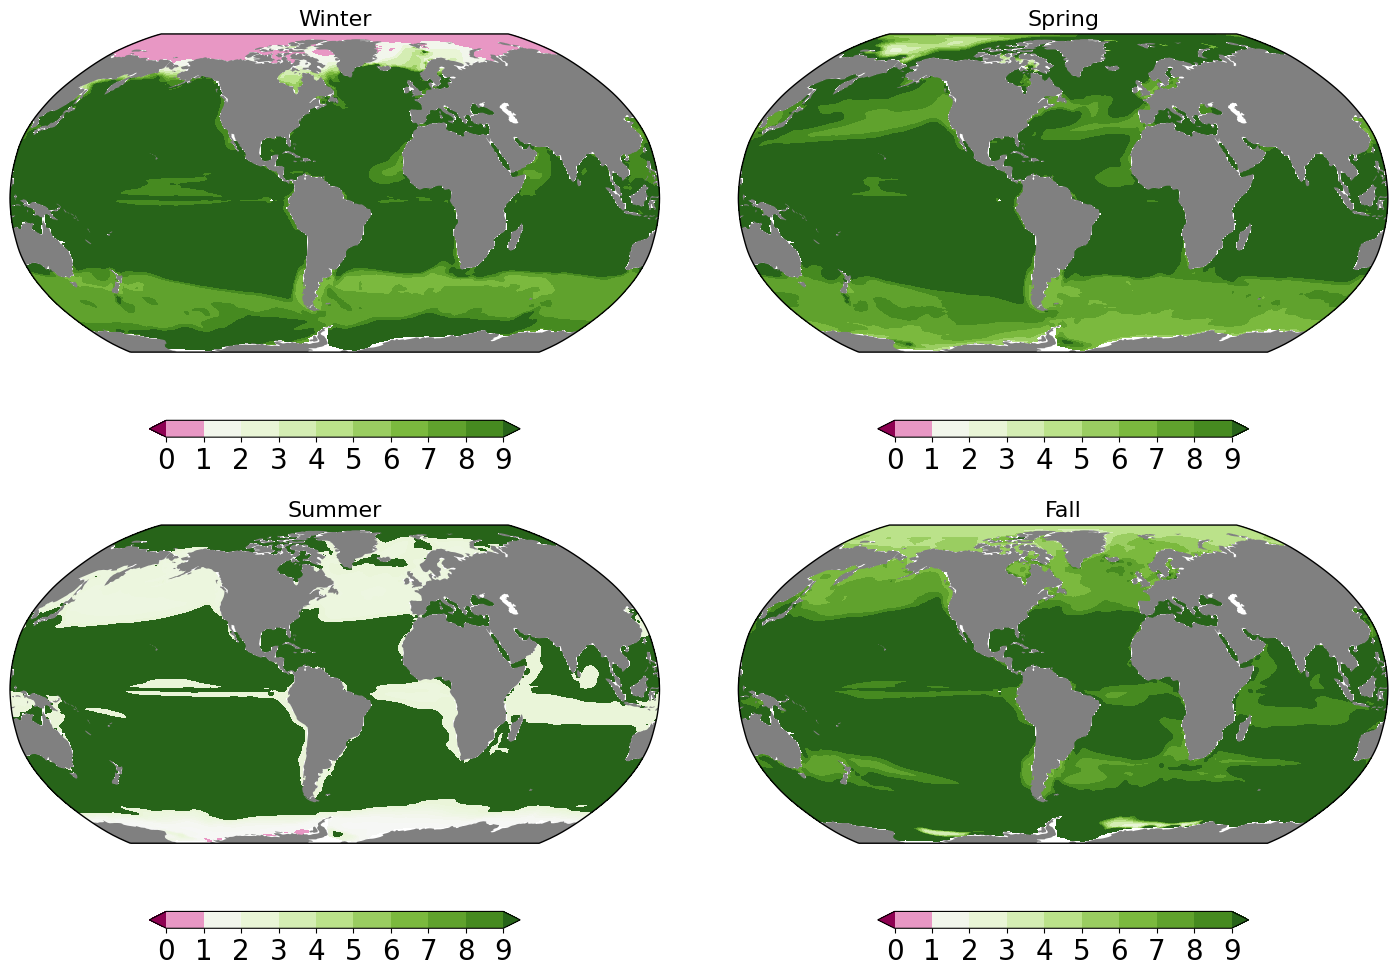

In [54]:
fig = plt.figure(figsize=(15, 10))
lat = ds.TLAT
lev = np.arange(0, 10, 1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)

## WINTER 
ax = fig.add_subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_zoo_winter/zoo_zoo_winter)
cf = ax.contourf(tlon, tlat, phyto, vmin=0, vmax=10,levels=lev,norm=norm, extend='both',cmap='PiYG',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =16)


## SPRING
ax = fig.add_subplot(2, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_zoo_spring/zoo_zoo_spring)
cf = ax.contourf(tlon, tlat, phyto, vmin=0, vmax=10,levels=lev,norm=norm, extend='both',cmap='PiYG',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =16)

## SUMMER
ax = fig.add_subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_zoo_summer/zoo_zoo_summer)
cf = ax.contourf(tlon, tlat, phyto, vmin=0, vmax=50,levels=lev,norm=norm, extend='both',cmap='PiYG',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Summer', fontsize =16)


##FALL
ax = fig.add_subplot(2, 2, 4, projection=ccrs.Robinson(central_longitude=305.0))
tlon, tlat, phyto = adjust_pop_grid(ds.TLONG, ds.TLAT, phyto_zoo_fall/zoo_zoo_fall)
cf = ax.contourf(tlon, tlat, phyto, vmin=0, vmax=10,levels=lev,norm=norm, extend='both',cmap='PiYG',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cb = plt.colorbar(cf,shrink=0.5,orientation='horizontal')
cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =16);
fig.tight_layout()

fig.savefig('/glade/u/home/gabyn/work/case_notes/analysis_figures/global_Z&P_grazing_fraction_quarterly_150m.png',dpi=200, bbox_inches='tight')

In [7]:
%%time
phyto_zoo_winter = np.sum(phyto_zoo_sum_winter, axis=1) * 10/150 *(60*60*24*365) #integrate over depth #mmol m-3 y-1
phyto_zoo_spring = np.sum(phyto_zoo_sum_spring, axis=1) * 10/150 *(60*60*24*365) #integrate over depth #mmol m-3 y-1
phyto_zoo_summer = np.sum(phyto_zoo_sum_summer, axis=1) * 10/150 *(60*60*24*365) #integrate over depth #mmol m-3 y-1
phyto_zoo_fall = np.sum(phyto_zoo_sum_fall, axis=1) * 10/150 *(60*60*24*365) #integrate over depth #mmol m-3 y-1

CPU times: user 259 ms, sys: 423 ms, total: 682 ms
Wall time: 783 ms


In [8]:
%%time
zoo_zoo_winter = np.sum(zoo_zoo_sum_winter, axis=1) * 10/150 *(60*60*24*365) #integrate over depth #mmol m-3 y-1
zoo_zoo_spring = np.sum(zoo_zoo_sum_spring, axis=1) * 10/150 *(60*60*24*365) #integrate over depth #mmol m-3 y-1
zoo_zoo_summer = np.sum(zoo_zoo_sum_summer, axis=1) * 10/150 *(60*60*24*365) #integrate over depth #mmol m-3 y-1
zoo_zoo_fall = np.sum(zoo_zoo_sum_fall, axis=1) * 10/150 *(60*60*24*365) #integrate over depth #mmol m-3 y-1

CPU times: user 276 ms, sys: 277 ms, total: 554 ms
Wall time: 613 ms


In [9]:
phyto_zoo_frac_winter = phyto_zoo_winter/zoo_zoo_winter
phyto_zoo_frac_spring = phyto_zoo_spring/zoo_zoo_spring
phyto_zoo_frac_fall = phyto_zoo_fall/zoo_zoo_fall
phyto_zoo_frac_summer = phyto_zoo_summer/zoo_zoo_summer

## High vs low temperature 

In [10]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds_01= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [11]:
temp_ds_inter = np.empty([62,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:] = ds_01.TEMP[x[i]:x[i]+12,0,:,:]

In [12]:
temp_arctic = np.nanmean(temp_ds_inter[:,:,149:180,:], axis=(2,3))
temp_arctic_anom = temp_arctic-np.nanmean(temp_arctic,axis=0)
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
cold_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) < -(err_ao/2))
warm_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) > (err_ao/2))

In [13]:
cold_years_winter = phyto_zoo_frac_winter[cold_years_arctic,:,:] # 1/2 standard deviation 
warm_years_winter = phyto_zoo_frac_winter[warm_years_arctic,:,:] # 1/2 standard deviation 

cold_years_spring = phyto_zoo_frac_spring[cold_years_arctic,:,:] # 1/2 standard deviation 
warm_years_spring = phyto_zoo_frac_spring[warm_years_arctic,:,:] # 1/2 standard deviation 

cold_years_fall = phyto_zoo_frac_fall[cold_years_arctic,:,:] # 1/2 standard deviation 
warm_years_fall = phyto_zoo_frac_fall[warm_years_arctic,:,:] # 1/2 standard deviation 

cold_years_summer = phyto_zoo_frac_summer[cold_years_arctic,:,:] # 1/2 standard deviation 
warm_years_summer = phyto_zoo_frac_summer[warm_years_arctic,:,:] # 1/2 standard deviation 

## Low vs high ice years 

In [14]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds_02= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [15]:
ECOSYS_IFRAC_ds_inter = np.empty([62,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds_02.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [16]:
ice_arctic = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:180,:], axis=(2,3))
ice_arctic_anom = ice_arctic-np.nanmean(ice_arctic,axis=0)
err_ao = np.nanstd(ice_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) < -(err_ao/2))
high_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) > (err_ao/2))

In [17]:
low_ice_years_winter = phyto_zoo_frac_winter[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_winter = phyto_zoo_frac_winter[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_spring = phyto_zoo_frac_spring[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_spring = phyto_zoo_frac_spring[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_fall = phyto_zoo_frac_fall[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_fall = phyto_zoo_frac_fall[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_summer = phyto_zoo_frac_summer[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_summer = phyto_zoo_frac_summer[high_ice_years_arctic,:,:] # 1/2 standard deviation 

## Low vs high nutrient years

In [18]:
NO3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds_03= xr.open_mfdataset(NO3_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [19]:
NO3_ds_inter = np.empty([62,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    NO3_ds_inter[i,:,:,:] = ds_03.NO3[x[i]:x[i]+12,0,:,:]

In [20]:
no3_arctic = np.nanmean(NO3_ds_inter[:,:,149:180,:], axis=(2,3))
no3_arctic_anom = no3_arctic-np.nanmean(no3_arctic,axis=0)
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) < -(err_ao/2))
high_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) > (err_ao/2))

In [21]:
low_no3_years_winter = phyto_zoo_frac_winter[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_winter = phyto_zoo_frac_winter[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_spring = phyto_zoo_frac_spring[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_spring = phyto_zoo_frac_spring[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_fall = phyto_zoo_frac_fall[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_fall = phyto_zoo_frac_fall[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_summer = phyto_zoo_frac_summer[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_summer = phyto_zoo_frac_summer[high_no3_years_arctic,:,:] # 1/2 standard deviation 

## Publication ready figure

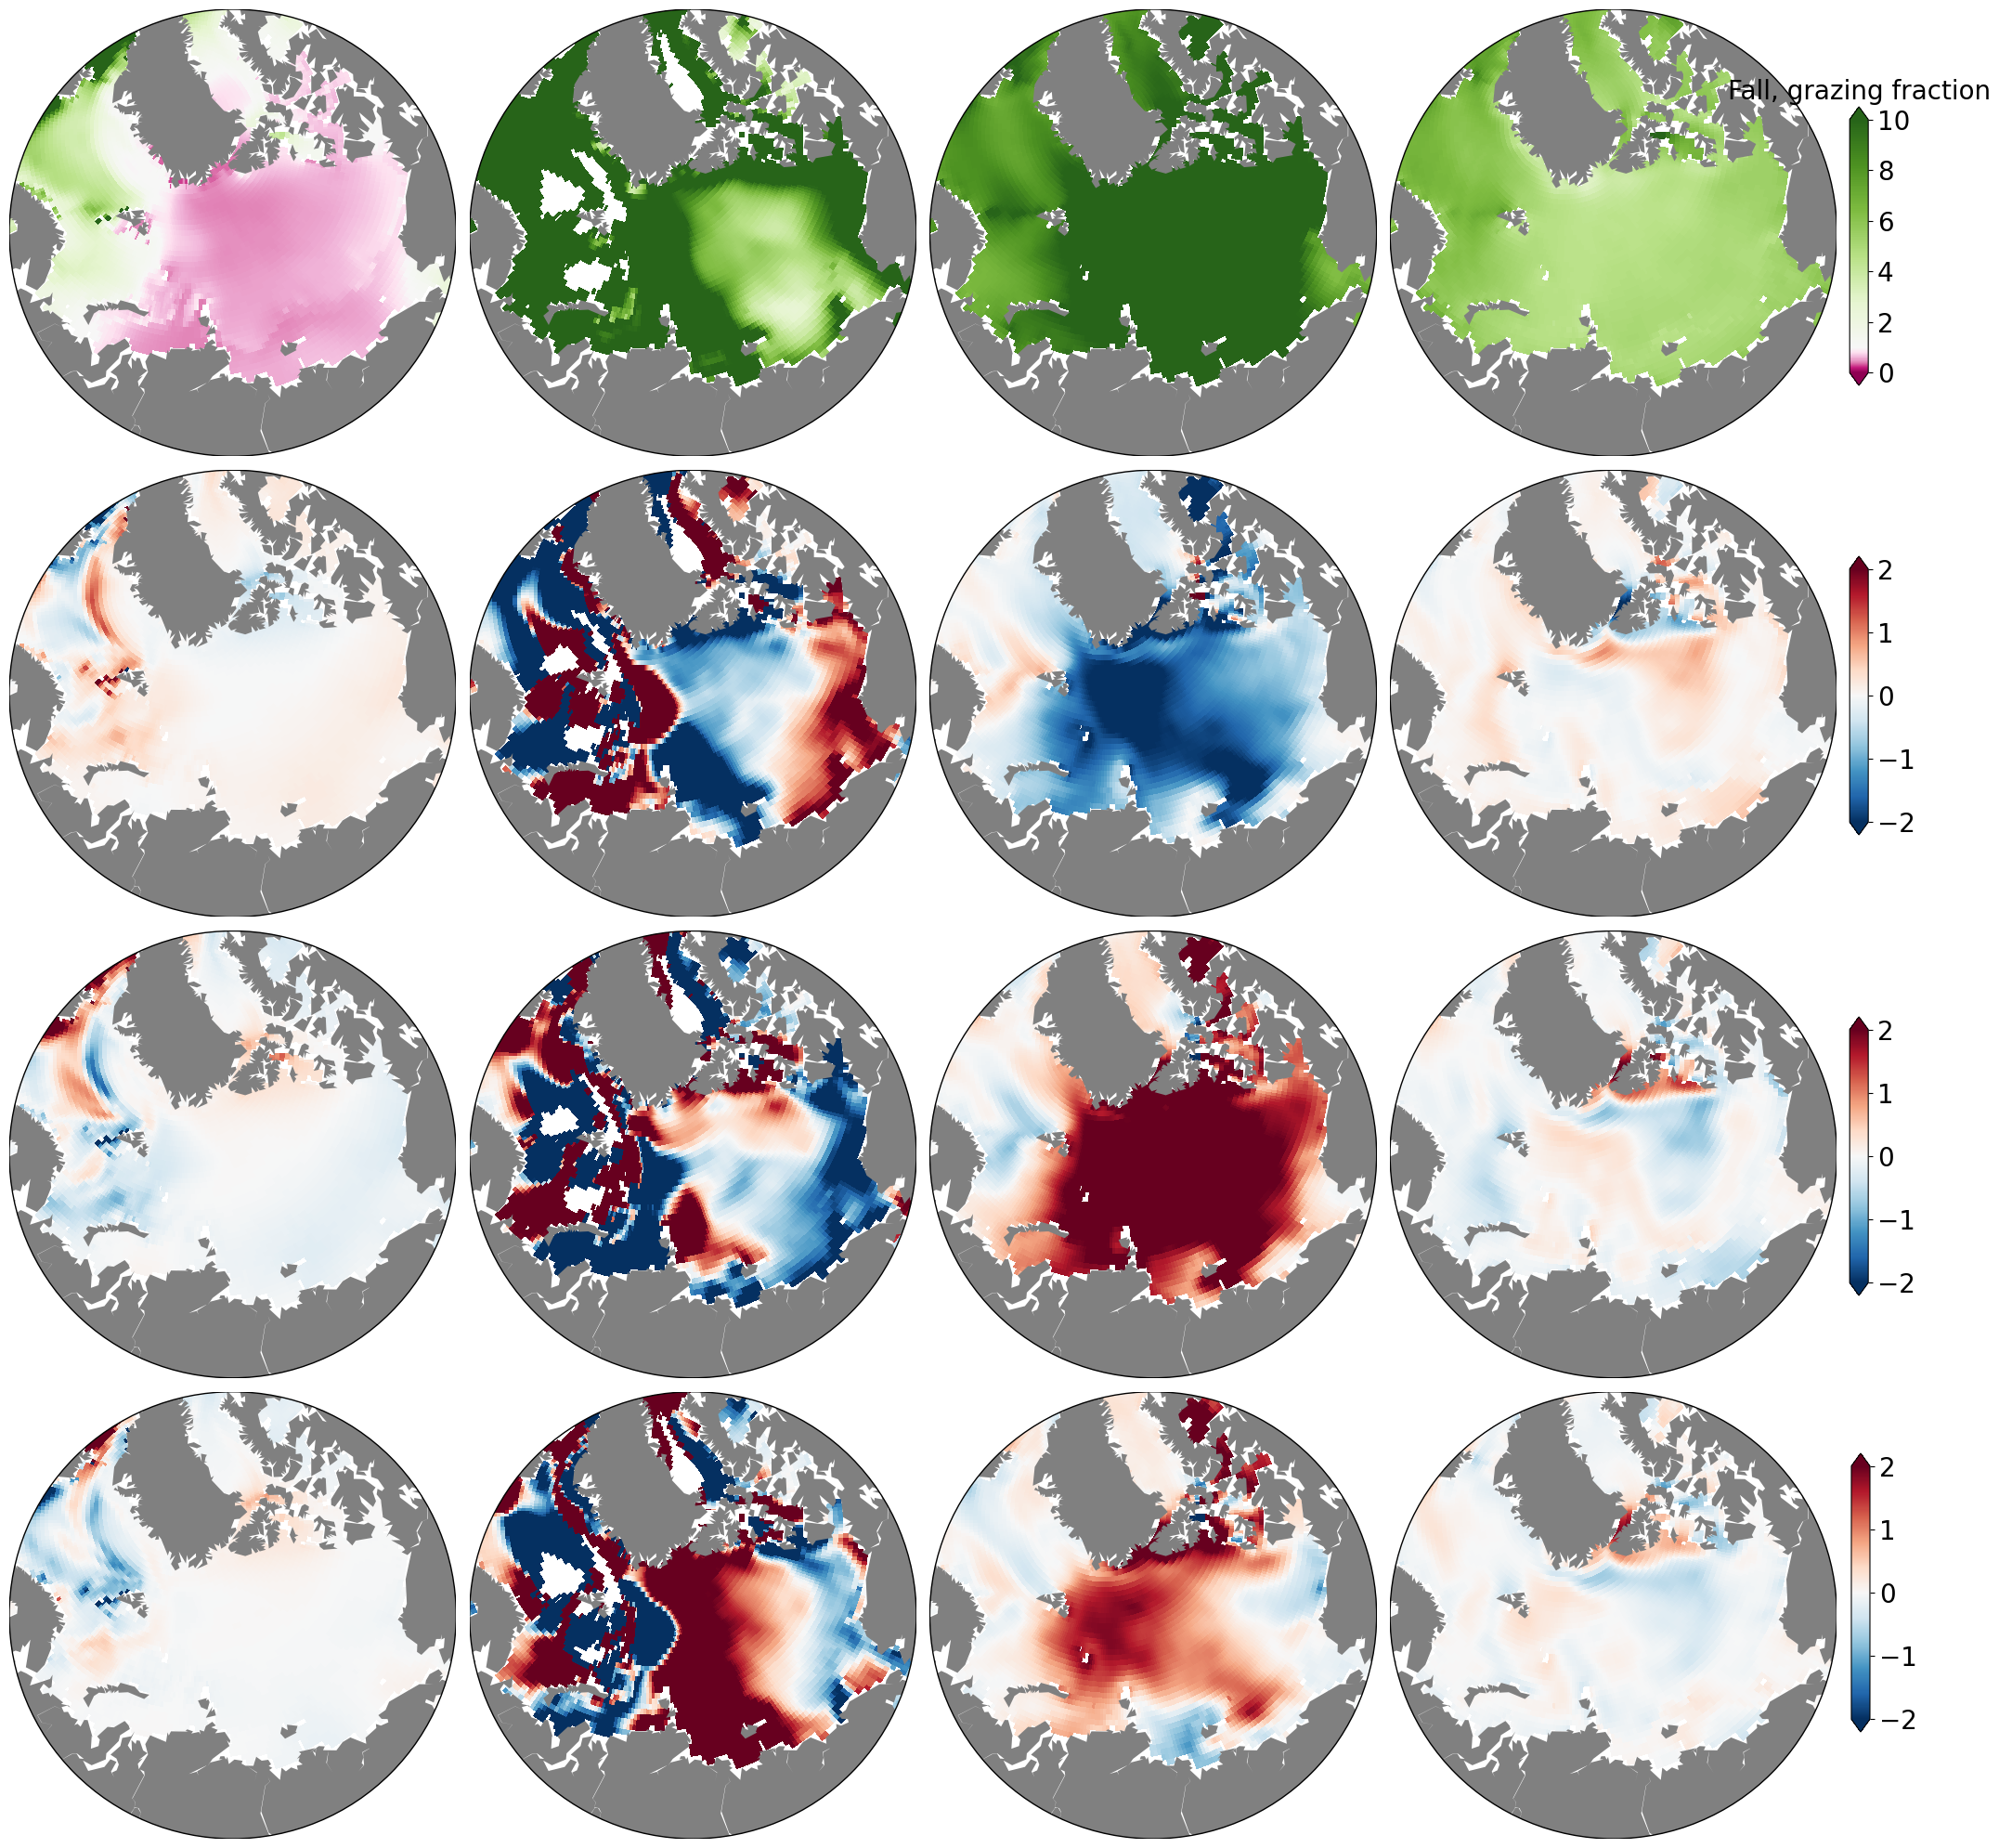

In [27]:
from mpl_toolkits.basemap import Basemap
lev = np.arange(0, 10, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
fig = plt.figure(figsize=(20, 20))

#### 62 year average!!! 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(phyto_zoo_frac_winter,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='PiYG', vmin = 0, vmax = 10, norm=norm);
ax.set_title('Winter, grazing fraction', fontsize=16)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(4, 4, 2)
lon, lat, spring = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(phyto_zoo_frac_spring,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, spring, cmap='PiYG', vmin = 0, vmax = 10,norm=norm);
ax.set_title('Spring, grazing fraction', fontsize=16)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 3)
lon, lat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(phyto_zoo_frac_summer,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, summer, cmap='PiYG', vmin = 0, vmax = 15,norm=norm);
ax.set_title('Summer, grazing fraction', fontsize=16)

# Fall TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 4, 4)
lon, lat, fall = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(phyto_zoo_frac_fall,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, fall, cmap='PiYG',vmin = 0, vmax = 10,norm=norm);
cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
ax.set_title('Fall, grazing fraction', fontsize=20)
cb.ax.tick_params(labelsize=20)

########## Differences!!! 
vminn =-2
vmaxx=2
# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
winter_temp_diff = np.nanmean(warm_years_winter,axis=(0,1))-np.nanmean(cold_years_winter,axis=(0,1))
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
spring_temp_diff = np.nanmean(warm_years_spring,axis=(0,1))-np.nanmean(cold_years_spring,axis=(0,1))
lon, lat, sp_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, spring_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
summer_temp_diff = np.nanmean(warm_years_summer,axis=(0,1))-np.nanmean(cold_years_summer,axis=(0,1))
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
fall_temp_diff = np.nanmean(warm_years_fall,axis=(0,1))-np.nanmean(cold_years_fall,axis=(0,1))
lon, lat, f_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, fall_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

## Ice Fraction

# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 9)
winter_ice_diff = np.nanmean(high_ice_years_winter, axis=(0,1))-np.nanmean(low_ice_years_winter, axis=(0,1))
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 10)
spring_ice_diff = np.nanmean(high_ice_years_spring, axis=(0,1))-np.nanmean(low_ice_years_spring, axis=(0,1))
lon, lat, sp_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, spring_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 11)
summer_ice_diff = np.nanmean(high_ice_years_summer, axis=(0,1))-np.nanmean(low_ice_years_summer, axis=(0,1))
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 12)
fall_ice_diff = np.nanmean(high_ice_years_fall, axis=(0,1))-np.nanmean(low_ice_years_fall, axis=(0,1))
lon, lat, f_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, fall_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)


# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
winter_no3_diff = np.nanmean(high_no3_years_winter, axis=(0,1))-np.nanmean(low_no3_years_winter, axis=(0,1))
lon, lat, w_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
spring_no3_diff = np.nanmean(high_no3_years_spring, axis=(0,1))-np.nanmean(low_no3_years_spring, axis=(0,1))
lon, lat, sp_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, spring_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
summer_no3_diff = np.nanmean(high_no3_years_summer, axis=(0,1))-np.nanmean(low_no3_years_summer, axis=(0,1))
lon, lat, s_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, summer_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);

# Fall, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = np.nanmean(high_no3_years_fall, axis=(0,1))-np.nanmean(low_no3_years_fall, axis=(0,1))
lon, lat, f_diff = adjust_pop_grid(ds.TLONG, ds.TLAT, fall_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()

fig.savefig('/glade/u/home/gabyn/work/case_notes/analysis_figures/quarterly_grazing_fraction_interannual.png',dpi=200, bbox_inches='tight')

### What does this figure tell us?
1. During the Winter net heterotophic grazing fluxes dominate throughout the Central Arctic Ocean. 
2. When comparing between years of high or low temperature, 
    - `(-) differences`: high temp (2) - low temp (2.1) = - 0.1 (-), a negative differnece value represents that the grazing fluxes become less autotrophic during high temperature years. 
    - `(+) differences`: high temp (2) - low temp (1.9) = 0.1 (+), a positive differnece value shows that grazing fluxes become more autotrophic during high temperature years. 

## Overview: 
1. `Winter` - heteroptrophic processes dominate 
2. `Summer`, `Spring` and `Fall` - autotrophic processes dominate 
3. Between high and low temperature years: 
    - `Winter` - grazing fluxes become more autotrophic during high temperature years. 
    - `Spring` - more autotorphic grazing fluxes around Chukchi Sea, and more heterotrophic fluxes around central Arctic and inflow shelves of the Barents Seas. 
    - `Summer` - autrotophic fluxes decrease during high temperature years.  
    - `Fall` - grazing fluxes become more autotrophic during high temperature years. 
4. Between high and low Ice Fraction years: 
    - `Winter` - grazing fluxes become more autotrophic during low ice years. 
    - `Spring` - less autotorphic grazing fluxes around Chukchi Sea, and more autotrophic fluxes around central Arctic and inflow shelves of the Barents Seas. 
    - `Summer` - less autrotophic fluxes during low ice years years.  
    - `Fall` - more autotrophic fluxes during less ice years. 
5. Between high and low NO3 years: 
    - `Winter` - grazing fluxes become more autotrophic during low NO3 years. 
    - `Spring` - less autotorphic grazing fluxes around Chukchi Sea, and more autotrophic fluxes around central Arctic and inflow shelves of the Barents Seas. 
    - `Summer` - less autrotophic fluxes during low NO3 years years.  
    - `Fall` - more autotrophic fluxes during less NO3 years. 